In [4]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [5]:
df_completo = pd.read_csv('data/acetylcholinesterase_02_bioactivity_data_preprocessed_token_descriptors.csv')

In [6]:
df_completo.columns

Index(['molecule_chembl_id', 'canonical_smiles', 'standard_value',
       'standard_value_norm', 'pIC50', 'X_seq', 'X_seq_pad', 'MW', 'LogP',
       'NumHDonors',
       ...
       'PubchemFP871', 'PubchemFP872', 'PubchemFP873', 'PubchemFP874',
       'PubchemFP875', 'PubchemFP876', 'PubchemFP877', 'PubchemFP878',
       'PubchemFP879', 'PubchemFP880'],
      dtype='object', length=894)

## Features para Random Forest
Se seleccionan solamente los descriptores fingerprints de cada sustancia, son  881 features

In [7]:
X= df_completo.drop(['molecule_chembl_id', 'canonical_smiles', 'standard_value',
       'standard_value_norm', 'pIC50', 'X_seq', 'X_seq_pad', 'MW', 'LogP',
       'NumHDonors', 'NumHAcceptors', 'bioactivity_class', 'Name'], axis=1)

In [8]:
X.columns # 881 Features

Index(['PubchemFP0', 'PubchemFP1', 'PubchemFP2', 'PubchemFP3', 'PubchemFP4',
       'PubchemFP5', 'PubchemFP6', 'PubchemFP7', 'PubchemFP8', 'PubchemFP9',
       ...
       'PubchemFP871', 'PubchemFP872', 'PubchemFP873', 'PubchemFP874',
       'PubchemFP875', 'PubchemFP876', 'PubchemFP877', 'PubchemFP878',
       'PubchemFP879', 'PubchemFP880'],
      dtype='object', length=881)

## Output para Random Forest
Sera el pi50, es una normalizacion del ic50 (escala logaritmica negativa) nos indica la concentración a la que un fármaco es capaz de inhibir un proceso biológico concreto en un 50%

In [9]:
y = df_completo.pIC50
y

0      6.12
1      7.00
2      4.30
3      6.52
4      6.10
       ... 
5098   3.58
5099   6.13
5100   6.29
5101   3.90
5102   4.00
Name: pIC50, Length: 5103, dtype: float64

In [10]:
# Shapes
X.shape, y.shape

((5103, 881), (5103,))

## Remove low variance features

In [11]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X_variance = selection.fit_transform(X)
X_variance.shape, X.shape # Reduccion de 881 a 140 features (elimino 741 features de baja varianza)

((5103, 140), (5103, 881))

## Split de Datos (80/20)

In [12]:

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
X_train_v, X_test_v, Y_train_v, Y_test_v = train_test_split(X_variance, y, test_size=0.2)

In [13]:
X_train.shape, Y_train.shape, X_train_v.shape, Y_train_v.shape

((4082, 881), (4082,), (4082, 140), (4082,))

In [14]:
X_test.shape, Y_test.shape, X_test_v.shape, Y_test_v.shape

((1021, 881), (1021,), (1021, 140), (1021,))

## MODELO RANDOM FOREST (PARA TODOS LOS FEATURES)

In [15]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
print('Metrica r2 de validacion:', r2)

Metrica r2 de validacion: 0.3440185942886924


<function matplotlib.pyplot.show(close=None, block=None)>

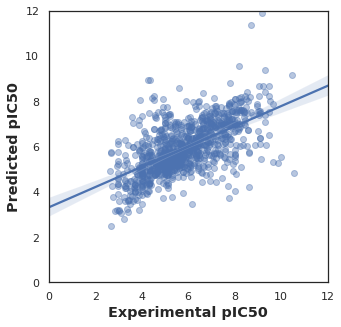

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt


Y_pred = model.predict(X_test)

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

## MODELO RANDOM FOREST (PARA FEATURES DE ALTA VARIANZA )

In [17]:
model_v = RandomForestRegressor(n_estimators=100)
model_v.fit(X_train_v, Y_train_v)
r2_v = model_v.score(X_test_v, Y_test_v)
print('Metrica r2 de validacion feature alta varianza:', r2_v)

Metrica r2 de validacion feature alta varianza: 0.2608419423126086


<function matplotlib.pyplot.show(close=None, block=None)>

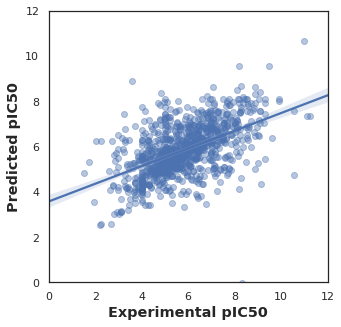

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt


Y_pred_v = model_v.predict(X_test_v)

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test_v, Y_pred_v, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

### RandomForest.score:
Return the coefficient of determination  of the prediction.

The coefficient R2 is defined as **(1 - u/v)**
 
, where  **u**  is the residual sum of squares ((y_true - y_pred) ** 2).sum() and **v** is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a  score of 0.0.

### Comparacion con varios Algoritmos de ML

In [19]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

### Solo con Features de Alta varianza

In [26]:
clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
# test sobre los mismo datos de entrenamiento
models_train,predictions_train = clf.fit(X_train_v, X_train_v, Y_train_v, Y_train_v)
predictions_train

100%|██████████| 42/42 [09:19<00:00, 13.32s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GaussianProcessRegressor,0.80,0.81,0.74,48.59
DecisionTreeRegressor,0.80,0.81,0.74,0.30
ExtraTreeRegressor,0.80,0.81,0.74,0.30
ExtraTreesRegressor,0.80,0.81,0.74,9.33
RandomForestRegressor,0.75,0.76,0.83,7.55
XGBRegressor,0.74,0.75,0.85,59.33
BaggingRegressor,0.72,0.73,0.88,1.12
MLPRegressor,0.65,0.67,0.98,121.41
HistGradientBoostingRegressor,0.54,0.56,1.13,125.84


In [24]:
#train y test con dataset distintos
models, predictions_test = clf.fit(X_train_v, X_test_v, Y_train_v, Y_test_v)
predictions_test

100%|██████████| 42/42 [08:14<00:00, 11.77s/it]


In [25]:
predictions_test

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LGBMRegressor,0.22,0.32,1.29,104.52
HistGradientBoostingRegressor,0.22,0.32,1.29,89.95
NuSVR,0.19,0.31,1.30,5.19
SVR,0.19,0.31,1.30,6.71
RandomForestRegressor,0.16,0.27,1.33,9.82
GradientBoostingRegressor,0.14,0.26,1.35,2.98
KNeighborsRegressor,0.13,0.25,1.35,1.64
XGBRegressor,0.11,0.23,1.37,61.11
MLPRegressor,0.08,0.21,1.39,140.33


### Con todos los Features

In [27]:
clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
# test sobre los mismo datos de entrenamiento
models_train_all_feature, predictions_test_all_feature = clf.fit(X_train, X_test, Y_train, Y_test)
predictions_test_all_feature

  5%|▍         | 2/42 [00:12<03:47,  5.69s/it]

## Conclusión:
Todos los modelos de Machine Learning que utiliza la lib LazyPredict poseen mucho overfitting, quizas haciendo tunning de los hiper-parametros se pueda mejorar los modelos. Por eso en la siguiente notebook vamos tratar de customizar y hacer tunning utilizando el algoritmo que mejor resultado dio en la bateria LazyPredict, **-->LGBM**